# Dendrogram example

#### This notebooks generate the json files needed to plot the [Dendrogram](https://gist.github.com/mdml/7537455) visualization.

Author: [Daniel Domingo-Fernández](https://github.com/ddomingof) 

In [1]:
import time
import sys
import os

from collections import defaultdict
import pandas as pd
import math
import scipy
import scipy.stats
import scipy.cluster
import numpy as np
import json
import matplotlib.pyplot as plt
from functools import reduce
import itertools as itt

from bio2bel_kegg.manager import Manager as KeggManager
from bio2bel_reactome.manager import Manager as ReactomeManager
from bio2bel_wikipathways.manager import Manager as WikiPathwaysManager


In [2]:
time.asctime()

'Tue Mar 13 14:41:57 2018'

In [3]:
print(sys.version)

3.4.5 (default, Dec 11 2017, 14:22:24) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-16)]


In [4]:
%matplotlib inline

Define location of gene set files via relative paths

In [5]:
#Location of the cloned repo
BASE_PATH = os.environ['COMPATH']
EXCELS_PATH = os.path.join(BASE_PATH,'src','compath','static','resources','excel')

In [6]:
kegg_excel = os.path.join(EXCELS_PATH,'kegg_gene_sets.xlsx')
reactome_excel= os.path.join(EXCELS_PATH,'reactome_gene_sets.xlsx')
wikipathways_excel = os.path.join(EXCELS_PATH,'wikipathways_gene_sets.xlsx')

In [7]:
def create_pathway_gene_set_dict(dataframe):
    """Creates a pathway genes dictionary
    
    :param pandas.DataFrame dataset: gene sets df
    :rtype: collections.defaultdict
    :returns: dictionary of pathway gene sets
    """
    
    pathway_dictionary = defaultdict(set)
    
    for pathway_name in dataframe: # iterate over columns in dataframe

        for gene in dataframe[pathway_name].unique():
            if not isinstance(gene, str): # There are NaN in the Pandas nArray
                continue

            pathway_dictionary[pathway_name].add(gene)
            
    return pathway_dictionary

Load KEGG

In [8]:
kegg_dataframe = pd.read_excel(kegg_excel, dtype=object)

kegg_pathways = create_pathway_gene_set_dict(kegg_dataframe)
        
try:
    assert (len(kegg_pathways.keys()) == 325)
except AssertionError as error:
    print('DataFrame does not contain 325 pathways, contains: {}'.format(len(kegg_pathways.keys())))
    

Load Reactome

In [9]:
reactome_dataframe = pd.read_excel(reactome_excel, dtype=object)

reactome_pathways = create_pathway_gene_set_dict(reactome_dataframe)

reactome_manager = ReactomeManager()

reactome_names_to_ids = reactome_manager.get_pathway_names_to_ids()

try:
    assert (len(reactome_names_to_ids.keys()) == 2162)
except AssertionError as error:
    print('Reactome Database contains {} pathways'.format(len(reactome_names_to_ids.keys()))) # Total of 2662 of those: 2132 are not empty
    
try:
    assert (len(reactome_pathways.keys()) == 2132)
except AssertionError as error:
    print('DataFrame does not contain 2132 pathways, contains: {}'.format(len(reactome_pathways.keys())))


Load WikiPathways

In [10]:
wikipathways_dataframe = pd.read_excel(wikipathways_excel, dtype=object)

wikipathways_pathways = create_pathway_gene_set_dict(wikipathways_dataframe)

wikipathways_manager = WikiPathwaysManager()

wikipathways_names_to_ids = wikipathways_manager.get_pathway_names_to_ids()

try:
    assert (len(wikipathways_names_to_ids.keys()) == 415)
except AssertionError as error:
    print('WikiPathways Database contains {} pathways'.format(len(wikipathways_names_to_ids.keys())))
    
try:
    assert (len(wikipathways_pathways.keys()) == 415)
except AssertionError as error:
    print('DataFrame does not contain 415 pathways, contains: {}'.format(len(wikipathways_pathways.keys())))

WikiPathways Database contains 420 pathways


Delete keys from the dict so the dendrogram is not big

In [11]:
subset_kegg_pathways = {}

for index, key in enumerate(kegg_pathways.keys()):
    if index < 30:
        subset_kegg_pathways[key] = kegg_pathways[key]
        
print("Dictionary size: {}".format(len(subset_kegg_pathways)))

Dictionary size: 30


In [12]:
def create_similarity_matrix(dataset):
    """Creates a similarity matrix for a given pathway-geneset dataset
    
    :param dict dataset: pathway gene set dictionary
    :rtype: pandas.DataFrame
    :returns: similarity matrix
    """
    
    index = sorted(dataset.keys())
    similarity_dataframe = pd.DataFrame(0.0, index=index, columns=index)
    
    for pathway_1, pathway_2 in itt.product(index, index):

        intersection = len(dataset[pathway_1].intersection(dataset[pathway_2]))
        smaller_set = min(len(dataset[pathway_1]), len(dataset[pathway_2]))
                
        similarity = float(intersection/smaller_set) # Formula to calculate similarity
            
        similarity_dataframe[pathway_1][pathway_2] = similarity
        
    return similarity_dataframe


# Similar to scipy.spatial.distance.pdist metric = 'correlation
def create_distance_matrix(dataframe):
    """Creates a distance matrix based on perason correlation and distance given the distance matrix
    
    :param pandas.DataFrame dataframe: distance matrix as pandasDataframe
    :rtype: pandas.DataFrame
    :returns: distance matrix
    """
    
    index = dataframe.columns
        
    distance_dataframe = pd.DataFrame(0.0, index=index, columns=index)
        
    for pathway_1, pathway_2 in itt.product(index, index):
        
        pearson_correlation = scipy.stats.pearsonr(dataframe[pathway_1],dataframe[pathway_2])
                
        distance_dataframe[pathway_1][pathway_2] = 1 - pearson_correlation[0]
        
    return distance_dataframe


Create and visualize similarity matrices

In [13]:
test_similarity_matrix = create_similarity_matrix(subset_kegg_pathways)

Cluster the pathways

In [14]:
clusters = scipy.cluster.hierarchy.linkage(test_similarity_matrix, method='average')
tree = scipy.cluster.hierarchy.to_tree(clusters, rd=False)

Labeling

In [15]:
# Create dictionary for labeling nodes by their IDs
labels = list(test_similarity_matrix.columns)
id2name = dict(zip(range(len(labels)), labels))

In [16]:
# scipy.cluster.hierarchy.dendrogram(clusters, labels=labels, orientation='right')

Data transformation for D3.js

In [17]:
# Create a nested dictionary from the ClusterNode's returned by SciPy
def add_node(node, parent):
    # First create the new node and append it to its parent's children
    newNode = dict(node_id=node.id, children=[])
    parent["children"].append(newNode)

    # Recursively add the current node's children
    if node.left: add_node(node.left, newNode)
    if node.right: add_node(node.right, newNode)
        

# Label each node with the names of each leaf in its subtree
def label_tree(n):
    # If the node is a leaf, then we have its name
    if len(n["children"]) == 0:
        leafNames = [id2name[n["node_id"]]]

    # If not, flatten all the leaves in the node's subtree
    else:
        leafNames = reduce(lambda ls, c: ls + label_tree(c), n["children"], [])

    # Delete the node id since we don't need it anymore and
    # it makes for cleaner JSON
    del n["node_id"]

    # Labeling convention: "-"-separated leaf names
    n["name"] = name = "-".join(sorted(map(str, leafNames)))

    return leafNames

In [18]:
# Initialize nested dictionary for d3, then recursively iterate through tree
d3Dendro = dict(children=[], name="Root1")
add_node(tree, d3Dendro)

In [19]:
test_tree = label_tree(d3Dendro["children"][0])

In [20]:
json.dump(d3Dendro, open("d3-dendrogram.json", "w"), sort_keys=True, indent=4)

### Test for a subset of specific pathways

Comparison of pathway clusters

Example for a list of pathways

In [21]:
def _get_gene_set(resource_name, pathway_name):
    """Returns the resource gene set dictionary
    
    :param str resource_name: name of the resource
    :param str pathway_name: name of the pathway
    :rtype: dict
    """
    
    if resource_name == 'kegg':
        return kegg_pathways[pathway_name]
    
    elif resource_name == 'reactome':
        return reactome_pathways[pathway_name]
    
    elif resource_name == 'wikipathways':
        return wikipathways_pathways[pathway_name]
    
    else:
        raise ValueError('Not valid resource. please update this function')


def similarity_matrix_from_pathway_list(pathway_list):
    """Creates a similarity matrix for a given pathway/resource list of tuples
    
    :param list[tuple[str,str]] pathway_list: list of tuples with resource pathway info
    :rtype: pandas.DataFrame
    :returns: similarity matrix
    """
    
    index = [
        name
        for name, resource in pathway_list
    ]
    
    similarity_dataframe = pd.DataFrame(0.0, index=index, columns=index)
    
    for pathway_1, pathway_2 in itt.product(pathway_list, repeat=2):
        
        gene_set_1 = _get_gene_set(pathway_1[1],pathway_1[0])
        gene_set_2 = _get_gene_set(pathway_2[1],pathway_2[0])

        intersection = len(gene_set_1.intersection(gene_set_2))
        smaller_set = min(len(gene_set_1), len(gene_set_2))
                        
        similarity = float(intersection/smaller_set) # Formula to calculate similarity
            
        similarity_dataframe[pathway_1[0]][pathway_2[0]] = similarity
        
    return similarity_dataframe

In [22]:
pathways = [
    ('Signaling by VEGF','reactome'), 
    ('Prolactin signaling pathway - Homo sapiens (human)', 'kegg'),
    ('Signaling by Non-Receptor Tyrosine Kinases', 'reactome'), 
    ('Proteoglycans in cancer - Homo sapiens (human)', 'kegg'), 
    ('Target Of Rapamycin (TOR) Signaling', 'wikipathways'),
    ('FoxO signaling pathway - Homo sapiens (human)', 'kegg'), 
    ('GPCR downstream signalling', 'reactome'), 
    ('Caloric restriction and aging', 'wikipathways'),
    ('Copper homeostasis', 'wikipathways')
]       

test_similarity_matrix_2 = similarity_matrix_from_pathway_list(pathways)


In [23]:
test_similarity_matrix_2

,Signaling by VEGF,Prolactin signaling pathway - Homo sapiens (human),Signaling by Non-Receptor Tyrosine Kinases,Proteoglycans in cancer - Homo sapiens (human),Target Of Rapamycin (TOR) Signaling,FoxO signaling pathway - Homo sapiens (human),GPCR downstream signalling,Caloric restriction and aging,Copper homeostasis
Signaling by VEGF,1.000000,0.228571,0.240741,0.409524,0.243243,0.142857,0.285714,0.250,0.037037
Prolactin signaling pathway - Homo sapiens (human),0.228571,1.000000,0.129630,0.400000,0.027027,0.457143,0.314286,0.125,0.092593
Signaling by Non-Receptor Tyrosine Kinases,0.240741,0.129630,1.000000,0.296296,0.054054,0.185185,0.148148,0.125,0.037037
Proteoglycans in cancer - Homo sapiens (human),0.409524,0.400000,0.296296,1.000000,0.162162,0.290076,0.221675,0.500,0.111111
Target Of Rapamycin (TOR) Signaling,0.243243,0.027027,0.054054,0.162162,1.000000,0.216216,0.108108,0.375,0.027027
FoxO signaling pathway - Homo sapiens (human),0.142857,0.457143,0.185185,0.290076,0.216216,1.000000,0.167939,0.500,0.129630
GPCR downstream signalling,0.285714,0.314286,0.148148,0.221675,0.108108,0.167939,1.000000,0.125,0.055556
Caloric restriction and aging,0.250000,0.125000,0.125000,0.500000,0.375000,0.500000,0.125000,1.000,0.250000
Copper homeostasis,0.037037,0.092593,0.037037,0.111111,0.027027,0.129630,0.055556,0.250,1.000000


Clustering calculating distance from pearson correlation. We compare our implementation vs the method scipy pdist function 

In [25]:
import scipy.spatial.distance as ssd

# Use our own function
distance_matrix_1 = create_distance_matrix(test_similarity_matrix_2)

distance_matrix_1 = ssd.squareform(distance_matrix_1)

In [26]:
distance_matrix_1

array([1.0399675 , 0.92564898, 0.68125487, 0.95408004, 1.30711477,
       0.86027304, 1.08610356, 1.43166317, 1.14086517, 0.7357057 ,
       1.43888096, 0.59824679, 0.77339255, 1.26392475, 1.2504176 ,
       0.88756579, 1.30999461, 1.1616927 , 1.10580531, 1.27813923,
       1.32240765, 1.16376845, 0.91703924, 1.08134487, 0.62165641,
       1.29060602, 1.02009967, 1.24856028, 0.66466437, 1.28309193,
       1.19865412, 0.55837002, 1.15951585, 1.38269781, 1.32672312,
       0.95070556])

In [27]:
# Use pdist function with correlation metric as an argument
distance_matrix_2 = ssd.pdist(test_similarity_matrix_2, metric= 'correlation')

clusters = scipy.cluster.hierarchy.linkage(distance_matrix_2, method='average')
#tree = scipy.cluster.hierarchy.to_tree(clusters, rd=False)

In [28]:
distance_matrix_2

array([1.0399675 , 0.92564898, 0.68125487, 0.95408004, 1.30711477,
       0.86027304, 1.08610356, 1.43166317, 1.14086517, 0.7357057 ,
       1.43888096, 0.59824679, 0.77339255, 1.26392475, 1.2504176 ,
       0.88756579, 1.30999461, 1.1616927 , 1.10580531, 1.27813923,
       1.32240765, 1.16376845, 0.91703924, 1.08134487, 0.62165641,
       1.29060602, 1.02009967, 1.24856028, 0.66466437, 1.28309193,
       1.19865412, 0.55837002, 1.15951585, 1.38269781, 1.32672312,
       0.95070556])

Histogram using the pdist method (1-R) where R is the pearson correlation

{'color_list': ['g', 'g', 'r', 'c', 'b', 'b', 'b', 'b'],
 'dcoord': [[0.0, 0.5583700236994469, 0.5583700236994469, 0.0],
  [0.0, 0.8423820184185021, 0.8423820184185021, 0.5583700236994469],
  [0.0, 0.7733925459341382, 0.7733925459341382, 0.0],
  [0.0, 0.6812548728341357, 0.6812548728341357, 0.0],
  [0.0, 0.9066073894631934, 0.9066073894631934, 0.6812548728341357],
  [0.7733925459341382,
   0.9939935986945413,
   0.9939935986945413,
   0.9066073894631934],
  [0.8423820184185021,
   1.128703580913065,
   1.128703580913065,
   0.9939935986945413],
  [0.0, 1.2518913630940807, 1.2518913630940807, 1.128703580913065]],
 'icoord': [[25.0, 25.0, 35.0, 35.0],
  [15.0, 15.0, 30.0, 30.0],
  [45.0, 45.0, 55.0, 55.0],
  [75.0, 75.0, 85.0, 85.0],
  [65.0, 65.0, 80.0, 80.0],
  [50.0, 50.0, 72.5, 72.5],
  [22.5, 22.5, 61.25, 61.25],
  [5.0, 5.0, 41.875, 41.875]],
 'ivl': ['Copper homeostasis',
  'Target Of Rapamycin (TOR) Signaling',
  'FoxO signaling pathway - Homo sapiens (human)',
  'Caloric restric

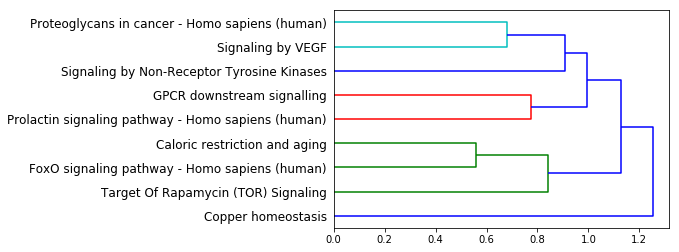

In [29]:
# Create dictionary for labeling nodes by their IDs
labels = list(test_similarity_matrix_2.columns)
id2name = dict(zip(range(len(labels)), labels))
scipy.cluster.hierarchy.dendrogram(clusters, labels=labels, orientation='right')